# Test our Ecohydrology module

This notebook is to test that importing and using our implementation of the Ecohydrology model works. 

In [1]:
from ecohydr_mod import EcoHyd
import numpy as np
import pandas as pd

In [2]:
def get_yearly_temp(csv_path, num_years):
    df = pd.read_csv(csv_path)
    df.dt = pd.to_datetime(df.dt)
    avg_temp_per_year = []
    max_temp_per_year = []
    min_temp_per_year = []
    for year in range(0, num_years):
        earliest_yr = df.iloc[0, 0].year
        year = year + earliest_yr
        if len(df.loc[(df.dt.dt.year == year), :]) > 365:
            avg_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'AverageTemperature'].iloc[:-1].tolist())
            max_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MaxTemperature'].iloc[:-1].tolist())
            min_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MinTemperature'].iloc[:-1].tolist())
        else:
            avg_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'AverageTemperature'].tolist())
            max_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MaxTemperature'].tolist())
            min_temp_per_year.append(df.loc[(df.dt.dt.year == year), 'MinTemperature'].tolist())
    
    return avg_temp_per_year, max_temp_per_year, min_temp_per_year

In [3]:
#get input temperature data
avg, maxi, mini = get_yearly_temp('new_temp_data.csv', 4)

In [4]:
len(avg[0])

365

In [5]:
WSA_array = np.zeros((51,51))
# Set 20 random values to 1
indices_to_set = np.random.choice(range(51 * 51), size=20, replace=False)
row_indices, col_indices = np.unravel_index(indices_to_set, (51, 51))
WSA_array[row_indices, col_indices] = int(1)

Ecohyd_model = EcoHyd(20, 26, 23)

landlab T:  23


In [6]:
import matplotlib.pyplot as plt

In [7]:
biomass_harvest, SM_canic_end = Ecohyd_model.stepper(WSA_array, avg[0], maxi[0], mini[0])

0
0
0
input T:  25.78
landlab T:  25.78
soil moisture sat.: [ 0.66349814  0.66349225  0.66348661 ...,  0.66776321  0.66776762
  0.6677722 ]
live biomass:  [ 99.5811424  99.5811424  99.5811424 ...,  99.5811424  99.5811424
  99.5811424]
ET:  [ 3.72415693  3.72553263  3.72685122 ...,  2.72052903  2.71948413
  2.71839785]
ET30:  [ 3.72415693  3.72553263  3.72685122 ...,  2.72052903  2.71948413
  2.71839785]
PFT:  [0 0 0 ..., 0 0 0]
0
0
0
input T:  26.44
landlab T:  26.44
soil moisture sat.: [ 0.62291167  0.62290104  0.62289086 ...,  0.63055688  0.63056473
  0.63057288]
live biomass:  [ 97.21964628  97.21964628  97.21964628 ...,  97.21964628  97.21964628
  97.21964628]
ET:  [ 3.81973941  3.82115042  3.82250285 ...,  2.79035286  2.78928114
  2.78816699]
ET30:  [ 3.81973941  3.82115042  3.82250285 ...,  2.79035286  2.78928114
  2.78816699]
PFT:  [0 0 0 ..., 0 0 0]
1
0.0027397260273972603
0
input T:  25.99
landlab T:  25.99
soil moisture sat.: [ 0.56694593  0.56692044  0.566896   ...,  0.58507

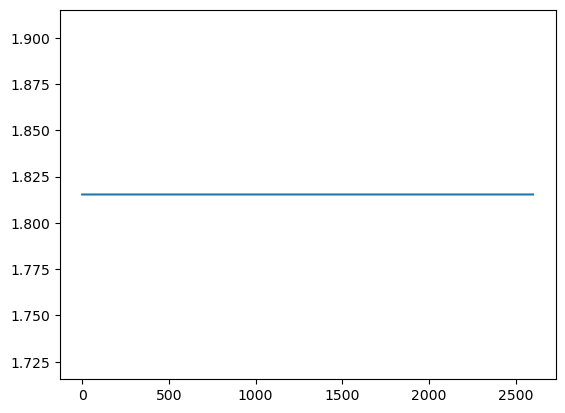

In [8]:
plt.plot(Ecohyd_model.mg.at_cell['rainfall__daily_depth'])

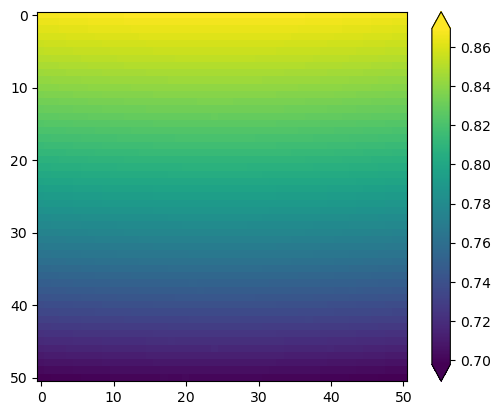

In [9]:
plt.imshow(np.reshape(Ecohyd_model.mg.at_cell['surface__evapotranspiration'], (51,51)))
plt.colorbar(extend = 'both')

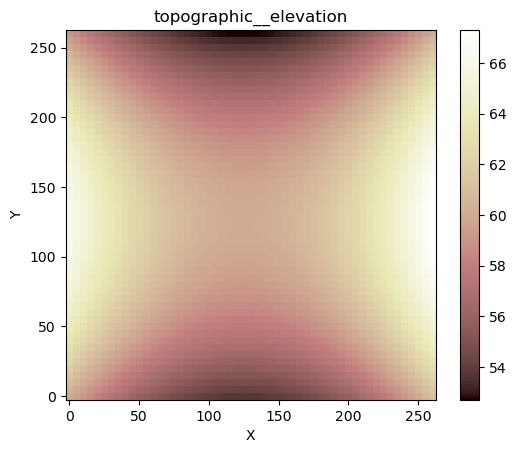

In [10]:
from landlab.plot.imshow import imshow_grid_at_node
#N.B. the Landlab user guide tells you to import the wrong component here

plt.figure('Elevations from the field')  # new fig, with a name
imshow_grid_at_node(Ecohyd_model.mg, 'topographic__elevation') 
plt.show()

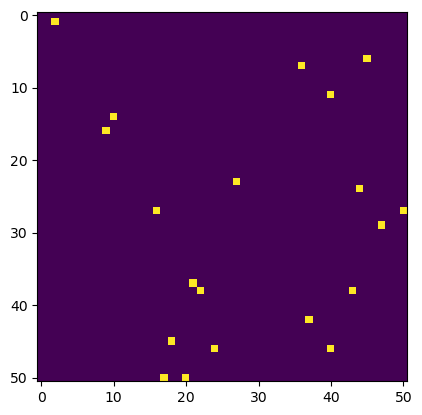

In [11]:
plt.imshow(WSA_array)

N.B the following images are all flipped upside-down because np.reshape assumes by default that the origin is in the top left, not the bottom left.

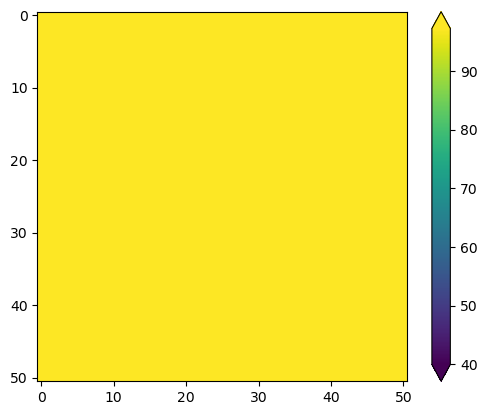

In [12]:
plt.imshow(np.reshape(biomass_harvest, (51,51)), vmin=40)
plt.colorbar(extend = 'both')

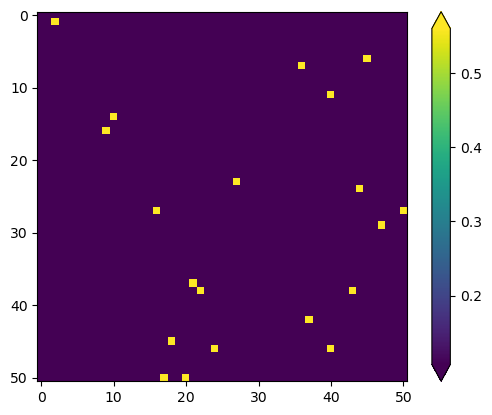

In [13]:
plt.imshow(np.reshape(SM_canic_end, (51,51)))
plt.colorbar(extend = 'both')

Why does WSA decrease soil moisture? A bit sus... Maybe there is still enough rainfall that the cover crop interception leads to less SM.

Almost more importantly though, we need to figure out what causes the weird artifact at the bottom of the plot (i.e., the North of the domain). Why is soil moisture there so much lower? As-is, this will dominate any potential effects from WSA.

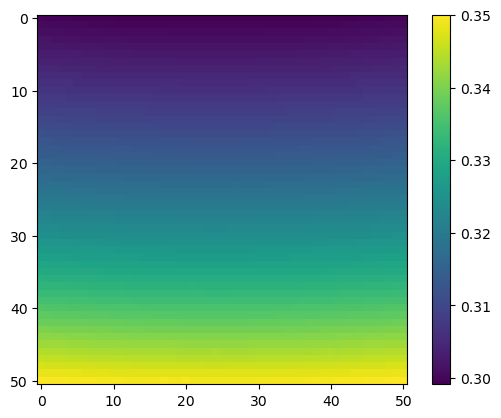

In [14]:
SM = np.reshape(Ecohyd_model.mg.at_cell['soil_moisture__saturation_fraction'], (51,51))
plt.imshow(SM)
plt.colorbar()

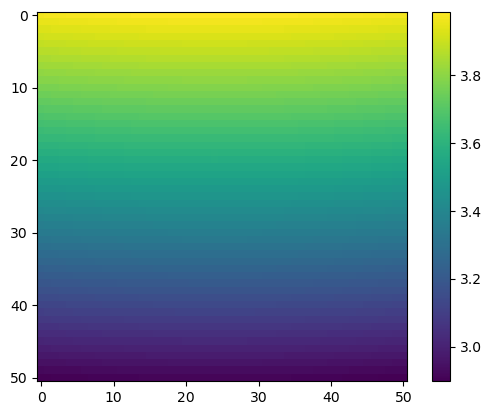

In [15]:
ET = np.reshape(Ecohyd_model.mg.at_cell['surface__potential_evapotranspiration_rate'], (51,51))
plt.imshow(ET)
plt.colorbar()

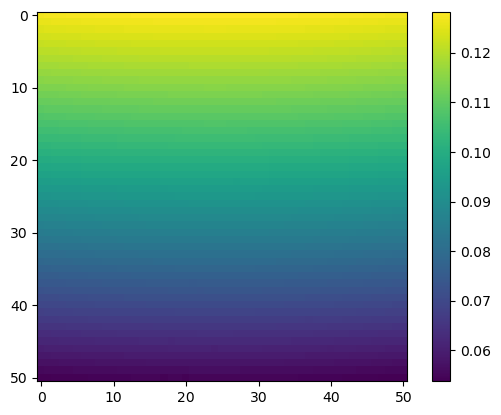

In [16]:
WS = np.reshape(Ecohyd_model.mg.at_cell['vegetation__water_stress'], (51,51))
plt.imshow(WS)
plt.colorbar()

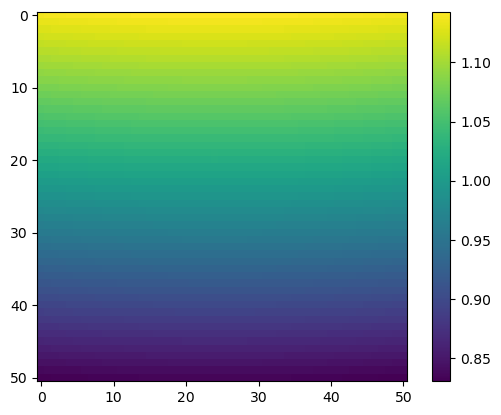

In [17]:
Rad_slope = np.reshape(Ecohyd_model.mg.at_cell['radiation__ratio_to_flat_surface'], (51,51))
plt.imshow(Rad_slope)
plt.colorbar()